In [1]:
%matplotlib inline 
import matplotlib.pylab as plt 
plt.rcParams.update({'figure.max_open_warning': 0})
import numpy as np 
import pandas as pd 
import seaborn as sns 
from xgboost import XGBClassifier
import sklearn.metrics as sklm
import sklearn.model_selection as ms
from sklearn.cluster.bicluster import SpectralBiclustering

In [2]:
def reduce_data(data,label_name):
    
    reduced_data = pd.DataFrame()

    for name,group in data.groupby('District'):
        drought_years = np.array(group[group[label_name]]['year'])
        keep_years = np.sort(np.unique(np.append(drought_years, [drought_years-1, drought_years+1])))
        temp = group[group.year.apply(lambda x: x in keep_years)].sort_values(by=['year', 'Season']).copy()
        reduced_data = pd.concat([reduced_data, temp])
        
    reduced_data.sort_values('year',inplace=True)
    reduced_data.reset_index(drop=True,inplace=True)
    
    return reduced_data

In [3]:
def balance_data(data, label_name, undersampling_seed=10):
    
    droughts_number = data[label_name].sum()
    
    negative_data = data[data[label_name]==False].copy()
    positive_data = data[data[label_name]==True].copy()
    balanced_data = pd.concat([negative_data.sample(n=droughts_number,replace=False,
                                    random_state=undersampling_seed,axis=0), positive_data])
    balanced_data.sort_values('year',inplace=True)
    balanced_data.reset_index(drop=True, inplace=True)
    
    return balanced_data

In [4]:
def make_temporal_split(data, selected_features, label_name, train_frac=0.8, test_frac=0.15):
    
    data.sort_values('year',inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    L = len(data)
    p1 = 1-test_frac
    p2 = train_frac

    train_val_ind = list(range(int(p1*L)))
    test_ind = list(range(np.max(train_val_ind)+1,L))
    L2 = len(train_val_ind)
    train_ind = list(range(int(p2*L2)))
    val_ind = list(range(np.max(train_ind)+1,L2))
    
    X = data[selected_features]
    y = data[label_name]

    X_train = data[selected_features].loc[train_ind]
    y_train = data[label_name].loc[train_ind]

    X_val = data[selected_features].loc[val_ind]
    y_val = data[label_name].loc[val_ind]

    X_test = data[selected_features].loc[test_ind]
    y_test = data[label_name].loc[test_ind]
    
    return X, y, X_train, y_train, X_val, y_val, X_test, y_test, train_ind, val_ind, test_ind

In [5]:
def do_gridsearch(X, y, opt_model, param_grid, cv, scoring, verbose=True):
    
    GS = ms.GridSearchCV(estimator = opt_model, param_grid = param_grid, 
                              cv = cv,
                              scoring = scoring,
                              return_train_score = True,n_jobs=4)
    GS.fit(X,y);
    
    for key in param_grid.keys():
        exec("opt_model." + key + "= GS.best_params_[key]")
    
    if verbose:
        print(GS.best_params_)
        print(scoring + ' = ',GS.best_score_)
    
    return opt_model

In [6]:
def fit_xgb_model(data, selected_features, label_name, undersampling_seed=10, train_frac=0.8, test_frac=0.15, 
                  scoring = 'f1_macro', verbose=True):
    
    reduced_data = reduce_data(data,label_name)
    
    balanced_data = balance_data(reduced_data, label_name, undersampling_seed)
    
    X, y, X_train, y_train, X_val, y_val, X_test, y_test, train_ind, val_ind, test_ind = make_temporal_split(balanced_data, 
                                                                                                             selected_features, 
                                                                                                             label_name, 
                                                                                                             train_frac, 
                                                                                                             test_frac) 
    
    opt_model=XGBClassifier()
    
    cv = ((np.array(train_ind),np.array(val_ind)),)
    
    # Optimizing 'max_depth' and 'min_child_weight'
    param_grid = {'max_depth':range(1,25,1),
                       'min_child_weight':[2,4,6,8,10,20,30,40,50]}

    opt_model = do_gridsearch(X,y,opt_model,param_grid,cv,scoring,verbose)
    
    # Optimizing gamma
    param_grid = {'gamma':[i/100.0 for i in range(0,100)]}

    opt_model = do_gridsearch(X,y,opt_model,param_grid,cv,scoring,verbose)
    
    # Optimizing subsample and colsample_bytree
    param_grid = {'subsample':[i/10.0 for i in range(6,11)],
                       'colsample_bytree':[i/10.0 for i in range(6,11)]}

    opt_model = do_gridsearch(X,y,opt_model,param_grid,cv,scoring,verbose)
    
    # Optimizing reg_alpha
    param_grid = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}

    opt_model = do_gridsearch(X,y,opt_model,param_grid,cv,scoring,verbose)
    
    opt_model.fit(X_train,y_train)
    
    y_pred_val = opt_model.predict(X_val)
    
    y_pred_test = opt_model.predict(X_test)
    
    return opt_model, X, y, X_train, y_train, X_val, y_val, X_test, y_test, y_pred_val, y_pred_test 

In [7]:
def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores, labels=[True,False])
    conf = sklm.confusion_matrix(labels, scores, labels=[True,False])
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print('Average F-score  %0.2f' % sklm.f1_score(labels, scores, labels=[True,False], average='macro'))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F-score    %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])

In [8]:
def get_feature_importances(model,colnames,n):
    feature_importances = pd.DataFrame()
    feature_importances['features'] = colnames
    feature_importances['importance'] = model.feature_importances_ 
    feature_importances.sort_values(by='importance',ascending=False, inplace=True)
    feature_importances.reset_index(drop=True,inplace=True)
    feature_importances.set_index('features').iloc[0:n].plot.barh(figsize=(8,3))
    #plt.xticks(rotation='vertical')
    return feature_importances.head(n)

In [9]:
filename = './datasets/Uganda_seasonal_normalized.csv'
data = pd.read_csv(filename)
data.dropna(inplace=True)
data.head()

,year,District,Season,EVI,NDVI,SPEI_3month,SoilMoisture00_10cm,SoilMoisture100_200cm,SoilMoisture10_40cm,SoilMoisture40_100cm,...,SoilTemperature40_100cm,air_temperature,evapotranspiration,precipitation_per_hour_v1,precipitation_per_hour_v2,rainfall,surface_temperature_daytime,surface_temperature_nighttime,wind_speed,drought_reported
0,2000,ABIM,11_12,0.635496,0.232554,0.946693,0.876312,0.199678,0.736812,0.605763,...,-0.552902,-0.435935,1.208654,1.601028,-0.469460,1.336204,-0.151764,-1.343323,-0.412148,False
1,2000,ABIM,6_7,-1.590836,-1.720571,0.075238,-1.302612,-1.113239,-1.262019,-0.937505,...,1.414168,1.570308,-0.740945,-0.358292,-1.030145,-0.388903,1.260564,0.032762,0.306375,False
2,2000,ADJUMANI,11_12,-1.085335,-1.260320,-0.606487,-0.724946,-0.722124,-0.683251,-0.829818,...,0.199455,-0.221168,-1.138716,0.041021,-2.093348,-1.024165,1.721439,-1.782573,-0.412293,False
3,2000,ADJUMANI,6_7,-2.697474,-3.056846,-0.816605,-0.872943,0.243240,-0.161562,0.000243,...,1.332993,1.546512,-0.115219,-1.671680,-1.859843,-0.681410,2.350867,-0.480881,0.608132,False
4,2000,AGAGO,11_12,1.149972,-0.070580,0.824262,0.874588,0.624983,0.793872,0.710458,...,-0.539216,-0.380892,1.126550,1.366786,0.265181,0.963633,-0.414698,-2.063056,-0.467823,False


In [11]:
id_cols = ['year','District','Season']

label_name = 'drought_reported'

All_features = list(data.drop(labels=id_cols+[label_name], 
                                  axis=1).columns)

# Training the model on all the features

In [12]:
selected_features = All_features

opt_model, X, y, X_train, y_train, X_val, y_val, X_test, y_test, y_pred_val, y_pred_test = fit_xgb_model(data, 
                                                                                                         selected_features, 
                                                                                                         label_name,
                                                                                                         verbose=False)
print_metrics(y_test, y_pred_test)

                 Confusion matrix
                 Score positive    Score negative
Actual positive         4                 7
Actual negative         1                 8

Accuracy  0.60
Average F-score  0.58
 
           Positive      Negative
Num case       11             9
Precision    0.80          0.53
Recall       0.36          0.89
F-score      0.50          0.67


,features,importance
0,SoilTemperature40_100cm,0.352534
1,precipitation_per_hour_v2,0.126819
2,SPEI_3month,0.120388
3,SoilTemperature100_200cm,0.081843
4,EVI,0.056957
5,air_temperature,0.054033
6,SoilMoisture100_200cm,0.039843
7,wind_speed,0.038226
8,surface_temperature_nighttime,0.035658
9,surface_temperature_daytime,0.032407


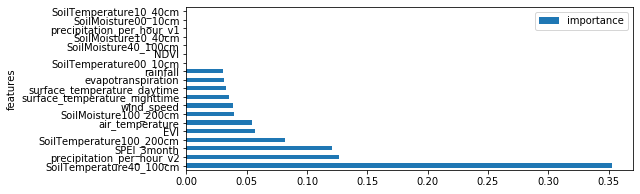

In [13]:
get_feature_importances(opt_model,selected_features,len(selected_features))

## Trainig Model on the most important features

In [14]:
selected_features = ['SoilMoisture00_10cm', 'precipitation_per_hour_v2'
                    ,'SPEI_3month']

opt_model, X, y, X_train, y_train, X_val, y_val, X_test, y_test, y_pred_val, y_pred_test = fit_xgb_model(data, 
                                                                                                         selected_features, 
                                                                                                         label_name,
                                                                                                         verbose=False)
print_metrics(y_test, y_pred_test)

                 Confusion matrix
                 Score positive    Score negative
Actual positive         5                 6
Actual negative         1                 8

Accuracy  0.65
Average F-score  0.64
 
           Positive      Negative
Num case       11             9
Precision    0.83          0.57
Recall       0.45          0.89
F-score      0.59          0.70


,features,importance
0,SPEI_3month,0.423697
1,precipitation_per_hour_v2,0.359403
2,SoilMoisture00_10cm,0.216900


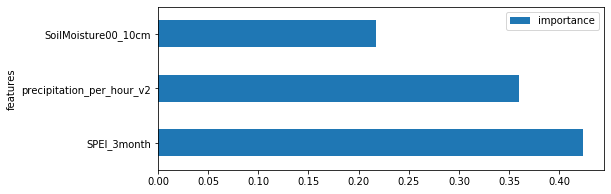

In [15]:
get_feature_importances(opt_model,selected_features,len(selected_features))